# Read basic data 

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import math 
import matplotlib.style as style
style.use('fivethirtyeight')

from helper import * 
df = pd.read_csv('data/GSPC.csv')

df.shape

C:\Users\Venkatramani\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(4723, 7)

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [4]:
df.Open.values

array([1469.25    , 1455.219971, 1399.420044, ..., 2902.540039,
       2877.530029, 2882.51001 ])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723 entries, 0 to 4722
Data columns (total 7 columns):
Date         4723 non-null object
Open         4723 non-null float64
High         4723 non-null float64
Low          4723 non-null float64
Close        4723 non-null float64
Adj Close    4723 non-null float64
Volume       4723 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 258.4+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4723.000000,4723.000000,4723.000000,4723.000000,4723.000000,4.723000e+03
mean,1490.391028,1498.963225,1481.159353,1490.577815,1490.577815,3.055488e+09
std,497.218669,497.378162,497.080972,497.342663,497.342663,1.504790e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1140.525024,1148.054993,1132.520019,1140.554993,1140.554993,1.598750e+09
50%,1331.910034,1340.890015,1324.969971,1331.939941,1331.939941,3.155080e+09
75%,1834.179993,1842.630005,1825.084961,1834.784973,1834.784973,3.917190e+09
max,2936.760010,2940.909912,2927.110107,2930.750000,2930.750000,1.145623e+10


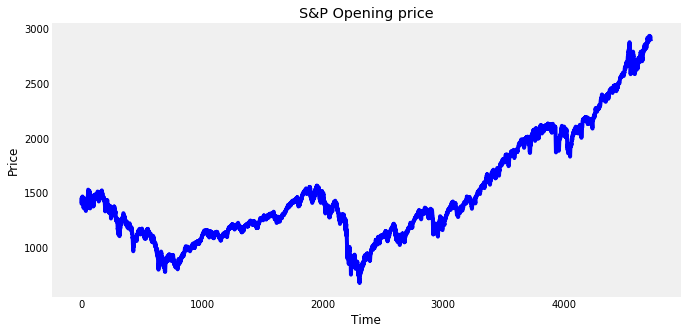

In [7]:
make_plot(df.Close.values, title= 'S&P Opening price', xlab='Time', ylab='Price', colour='blue')

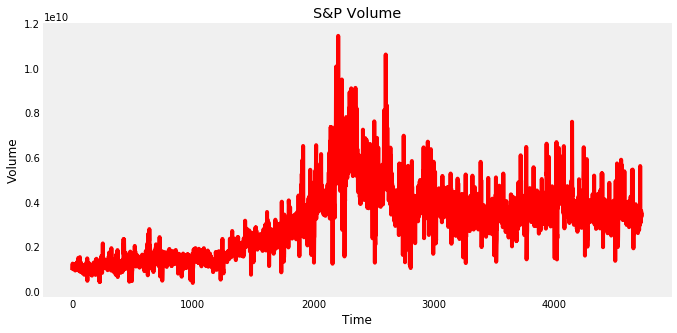

In [8]:
make_plot(df.Volume.values, title= 'S&P Volume', xlab='Time', ylab='Volume', colour='red')

# Data manipulation

In [9]:
dat = normalize_data(df.Close)

In [10]:
seq_len = 20

In [11]:
len(dat)

4723

In [12]:
x_train, y_train, x_valid, y_valid = load_data(inputdata=dat, seq_len = seq_len, val_percent = 0.1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)

x_train.shape =  (4233, 19, 1)
y_train.shape =  (4233, 1)
x_valid.shape =  (470, 19, 1)
y_valid.shape =  (470, 1)


# Modeling a RNN with (LSTM / GRU cells)

In [13]:
# parameters
n_steps = seq_len-1 
n_inputs = 1
n_neurons = 200 
n_outputs = 1
n_layers = 2
learning_rate = 0.001
batch_size = 50
training_iters = 100
train_set_size = x_train.shape[0]
test_set_size = x_valid.shape[0]
display_step = 10


tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
# tf.nn.elu are exponential linear units
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)


stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [14]:
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    step = 1    

    while step <= training_iters:
        
        sess.run(training_op, feed_dict={X: x_train, y:y_train})
        
        if step % display_step == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('Iter: ', step, 'MSE_Train = %.6f' % (mse_train), 'MSE_Validation = %.6f' % (mse_valid))
        
            y_train_pred = sess.run(outputs, feed_dict={X: x_train})
            y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
            
        step+=1
        
    print('Finished Optimization')

Iter:  10 MSE_Train = 0.005734 MSE_Validation = 0.059682
Iter:  20 MSE_Train = 0.002966 MSE_Validation = 0.030803
Iter:  30 MSE_Train = 0.000214 MSE_Validation = 0.001589
Iter:  40 MSE_Train = 0.000404 MSE_Validation = 0.001018
Iter:  50 MSE_Train = 0.000299 MSE_Validation = 0.000459
Iter:  60 MSE_Train = 0.000198 MSE_Validation = 0.000282
Iter:  70 MSE_Train = 0.000175 MSE_Validation = 0.000422
Iter:  80 MSE_Train = 0.000170 MSE_Validation = 0.000348
Iter:  90 MSE_Train = 0.000169 MSE_Validation = 0.000322
Iter:  100 MSE_Train = 0.000168 MSE_Validation = 0.000333
Finished Optimization


# Predictions

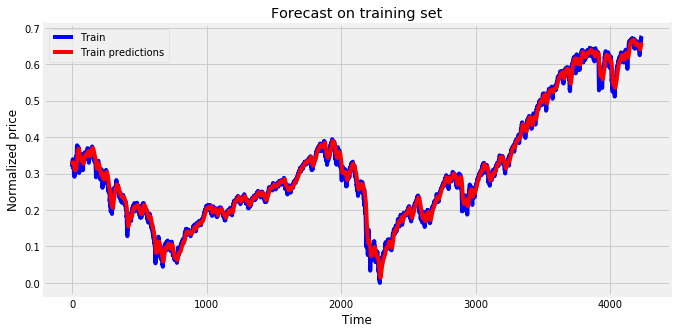

In [18]:
plt.figure(figsize=(10, 5));
plt.plot(y_train, color='blue', label='Train')
plt.plot(y_train_pred, color='red', label='Train predictions')
plt.title('Forecast on training set')
plt.xlabel('Time')
plt.ylabel('Normalized price')
plt.legend(loc='best');

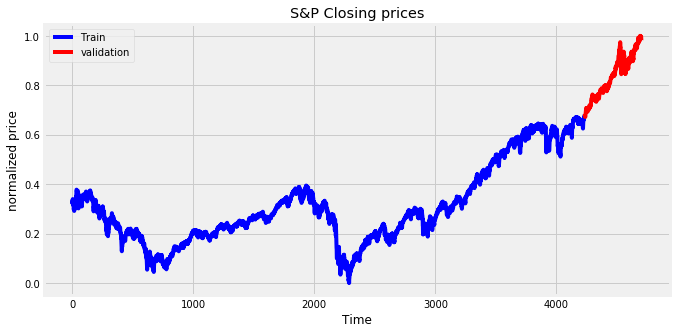

In [19]:
plt.figure(figsize=(10, 5));
plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='Train')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid, color='red', label='validation')

plt.title('S&P Closing prices')
plt.xlabel('Time')
plt.ylabel('normalized price')
plt.legend(loc='best');

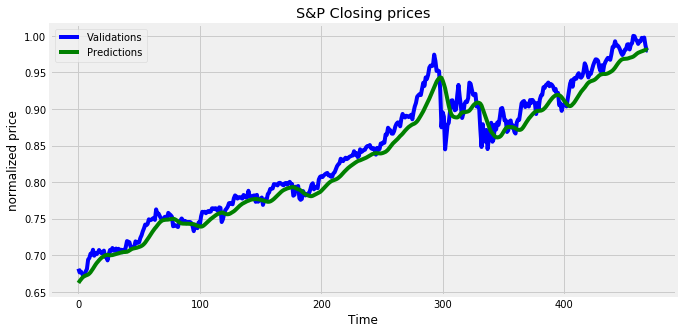

In [20]:
plt.figure(figsize=(10, 5));
plt.plot(np.arange(y_valid.shape[0]), y_valid, color='blue', label='Validations')
plt.plot(np.arange(y_valid_pred.shape[0]), y_valid_pred, color='green', label='Predictions')

plt.title('S&P Closing prices')
plt.xlabel('Time')
plt.ylabel('normalized price')
plt.legend(loc='best');